In [82]:
%load_ext autoreload
%autoreload 2

In [13]:
#---------------------------------------------------------
# View the 2D/3D parameter grid for the BOSZ models
#---------------------------------------------------------
import numpy as np
import scipy as sp
import os
import sys
import collections
import h5py
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as mp3d

from scipy import stats
%matplotlib inline

In [9]:
# Allow load project as module
sys.path.insert(0, '../')

In [10]:
from lv.constants import Constants as c

In [11]:
NORM_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux.h5"

In [18]:

with h5py.File(NORM_PATH, 'r') as f:
    para = f['para'][()]

In [20]:
MH    = para[:,0]
Teff  = para[:,1]
logG  = para[:,2]
CM    = para[:,3]
ALPHA = para[:,4]
uM = np.unique(MH)
uT = np.unique(Teff)
uG = np.unique(logG)
uC = np.unique(CM)
uA = np.unique(ALPHA)

In [26]:
def gridPts(ax,i,j):
    ix = (ALPHA == uA[i]) & (CM==uC[j]) & (Teff<=10000)
    ax.plot(Teff[ix]/1000,logG[ix],MH[ix],'.',markersize=2)
    
def plotGrid(i,j):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')    
    gridPts(ax,i,j)
    ax.set_xlabel('Teff')
    ax.set_ylabel('logG')
    ax.set_zlabel('MH')
    ax.view_init(70,65)
    plt.title(str(i)+':'+str(j))
    plt.draw()

def cuboid(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]     
    X += np.array(o)
    return X

def plotCube(lower,upper,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    sizes= []
    for l,u in zip(lower,upper):
        sizes.append((u[0]-l[0],u[1]-l[1], u[2]-l[2]))
    g = []
    for p,s,c in zip(lower,sizes,colors):
        g.append( cuboid(p,s))
    return mp3d.art3d.Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6), **kwargs)


# 

In [96]:
#--------------------------------------------
# create the block definitions for a 
# reasonable partitining with some overlap
#--------------------------------------------
Blocks = collections.namedtuple('Blocks',['let','name','lower','upper','color'])

def setBlocks():
    #-------------------------------------------------------------------------------
    # M. M31 Giants     :  Teff [3500, 5000]  Logg [0.00, 2.00]  M/H [-2.5, 0.0]
    # W. MW Warm MS     :  Teff [5500, 7500]  Logg [3.25, 5.00]  M/H [-2.0, 0.0]  
    # C. MW Cool MS     :  Teff [3750, 5750]  Logg [3.50, 5.00]  M/H [-2.0, 0.0]
    # B. Blue HB        :  Teff [6750, 9500]  Logg [2.00, 3.25]  M/H [-2.5,-1.5]
    # R. Red HB         :  Teff [5000, 6750]  Logg [2.00, 3.25]  M/H [-1.0, 0.0]
    # G. Dwarf G Giants :  Teff [4000, 5500]  Logg [1.00, 3.50]  M/H [-2.5,-1.0]
    #-------------------------------------------------------------------------------
    let   = ['M','W','C','B','R','G']
    name  = ['M31 Giants','MW Warm MS','MW Cool MS','Blue HB','Red HB', 'Dwarf G Giants']
    color = ['orange','lightgreen','brown','dodgerblue','red','fuchsia']
    lower, upper = [], []
    for R, bnds in c.dRs.items():
        bnds = np.array(bnds)[[1,2,0]].T
        bnds[:,0] /= 1000
        lower.append(list(bnds[0]))
        upper.append(list(bnds[1]))
    
#     lower = [(3.5,0.0,-2.5),(5.5,3.5,-2.0),(3.75,3.5,-2.0),(6.75,2.0,-2.5),(5.00,2.0,-1.0),(4.0,1.0,-2.5)]
#     upper = [(5.0,2.0, 0.0),(7.5,5.0, 0.0),(5.75,5.0, 0.0),(9.50,3.5,-1.5),(6.75,3.5, 0.0),(5.5,3.5,-1.0)]
    # old ranges
    #lower = [(3.5,0.0,-2.5),(5.5,3.5,-2.0),(4.5,4.0,-2.0),(7.0,2.0,-2.5),(5.0,2.0,-1.0),(3.5,0.0,-2.5)]
    #upper = [(5.0,2.0, 0.0),(7.5,5.0, 0.0),(6.0,5.0, 0.0),(9.5,3.0,-1.5),(6.5,3.0, 0.0),(5.5,3.5,-1.0)]
    
    return Blocks(let,name,lower,upper,color)

blk = setBlocks()

print(blk.let)
print(blk.name)
print(blk.lower)
print(blk.upper)
print(blk.color)


['M', 'W', 'C', 'B', 'R', 'G']
['M31 Giants', 'MW Warm MS', 'MW Cool MS', 'Blue HB', 'Red HB', 'Dwarf G Giants']
[[3.5, 0.0, -2.5], [5.5, 3.5, -2.0], [3.75, 3.5, -2.0], [6.75, 2.0, -2.5], [5.5, 2.0, -1.0], [4.0, 1.5, -2.5]]
[[5.0, 1.5, 0.0], [7.5, 5.0, 0.0], [5.5, 5.0, 0.0], [9.5, 3.5, -1.5], [6.75, 3.5, 0.0], [5.5, 3.5, -1.0]]
['orange', 'lightgreen', 'brown', 'dodgerblue', 'red', 'fuchsia']


In [100]:
def showBlocks3D(blk, theta, phi, label=''):
    #---------------------------------------------------------
    # take the block definitions and the viewing angle
        
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')

    pc = plotCube(blk.lower,blk.upper,colors=blk.color,edgecolor="k", lw=0.5, alpha=0.3)
    ax.add_collection3d(pc)    

    ax.set_xlim([10,3])
    ax.set_ylim([5,0])
    ax.set_zlim([-3,0.5])

    ax.set_xlabel('Teff/1000')
    ax.set_ylabel('logG')
    ax.set_zlabel('M/H')
    
    for i in range(len(blk.let)):
        p = blk.lower[i];
        ax.plot(*p,'s',color=blk.color[i],markersize=4)
    
    gridPts(ax,1,1)
        
    ax.legend(blk.name,markerscale=2)
    
    ax.view_init(theta,phi)

    if (label!=''):
        plt.savefig('F-blocks-'+label+'.png');
    
    plt.show()
    
def showBlocks2D12(blk,flag=0):
    #--------------------------------------------
    # plot the 2D parameter grid and the blocks
    # in Teff and log g
    #--------------------------------------------
    ix = (MH ==-2) & (CM==0) & (ALPHA==0)
    fig = plt.figure(figsize=(16,10), facecolor="w")
    ax  = fig.add_subplot(111)
    
    
    ax.set_xlim((12500,3000))
    ax.set_ylim((6,-1))
    ax.set_xlabel('Teff')
    ax.set_ylabel('log g')
    
    for i in range(len(blk.let)):
        lo = blk.lower[i];
        hi = blk.upper[i];
        ax.add_patch(Rectangle((1000*lo[0],lo[1]),(hi[0]-lo[0])*1000,\
            hi[1]-lo[1], facecolor=blk.color[i],alpha=0.45,edgecolor=blk.color[i],lw=2))
    
    ax.legend(blk.name,markerscale=2)
    ax.plot(Teff[ix],logG[ix],'.') 
        
    if (flag>0):
        plt.savefig('F-grid-Teff-logG.png');
    plt.show()

def showBlocks2D23(blk,flag=0):
    #--------------------------------------------
    # plot the 2D parameter grid and the blocks
    # in Teff and log g
    #--------------------------------------------
    ix = (Teff == 6000) & (CM==0) & (ALPHA==0)
    fig = plt.figure(figsize=(16,10), facecolor="w")
    ax  = fig.add_subplot(111)
    
    
    ax.set_xlim((-3,1))
    ax.set_ylim((6,-1))
    ax.set_xlabel('M/H')
    ax.set_ylabel('log g')
    
    for i in range(len(blk.let)):
        lo = blk.lower[i];
        hi = blk.upper[i];
        ax.add_patch(Rectangle((lo[2],lo[1]),(hi[2]-lo[2]),\
            hi[1]-lo[1], facecolor=blk.color[i],alpha=0.45,edgecolor=blk.color[i],lw=2))
    
    ax.legend(blk.name,markerscale=2)
    ax.plot(MH[ix],logG[ix],'.') 
        
    if (flag>0):
        plt.savefig('F-grid-MH-logG.png');
    plt.show()

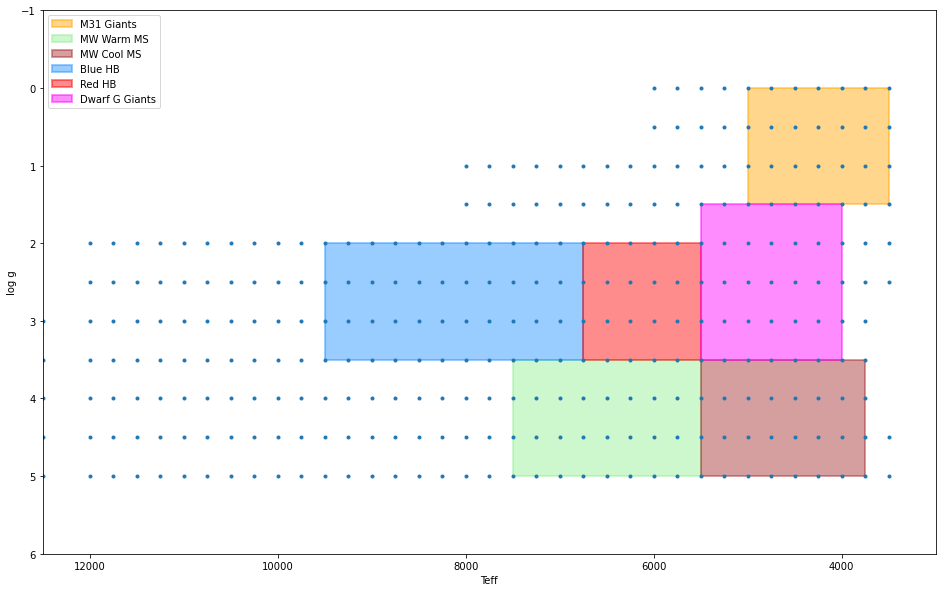

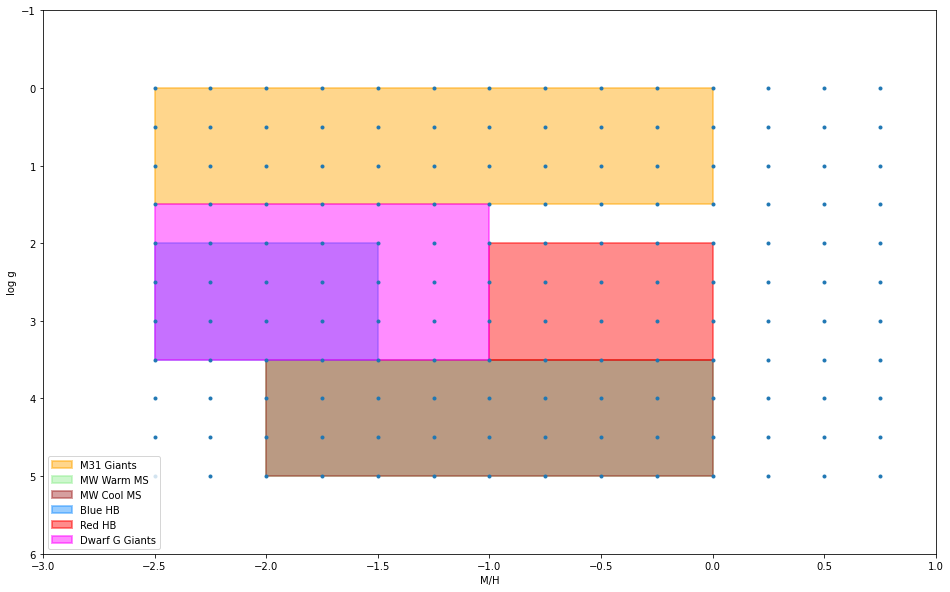

In [101]:
showBlocks2D12(blk,1)
showBlocks2D23(blk,1)

<ipython-input-100-62859022a745>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


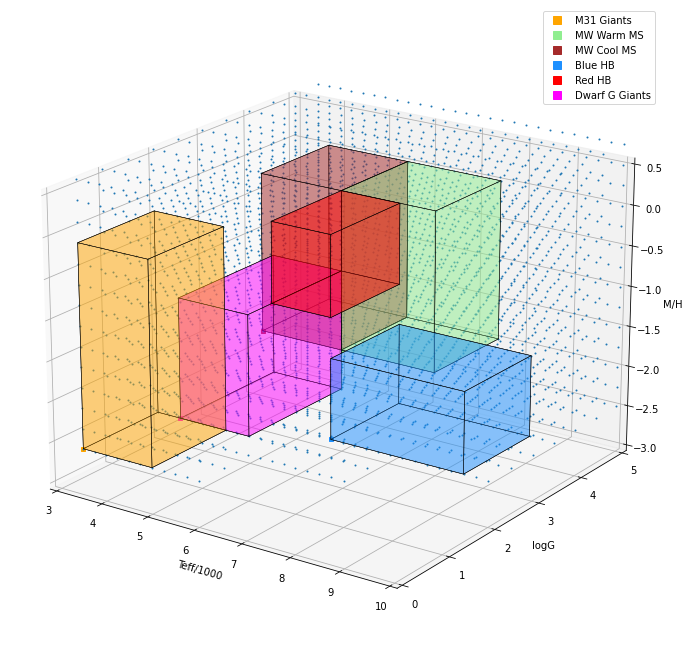

<ipython-input-100-62859022a745>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


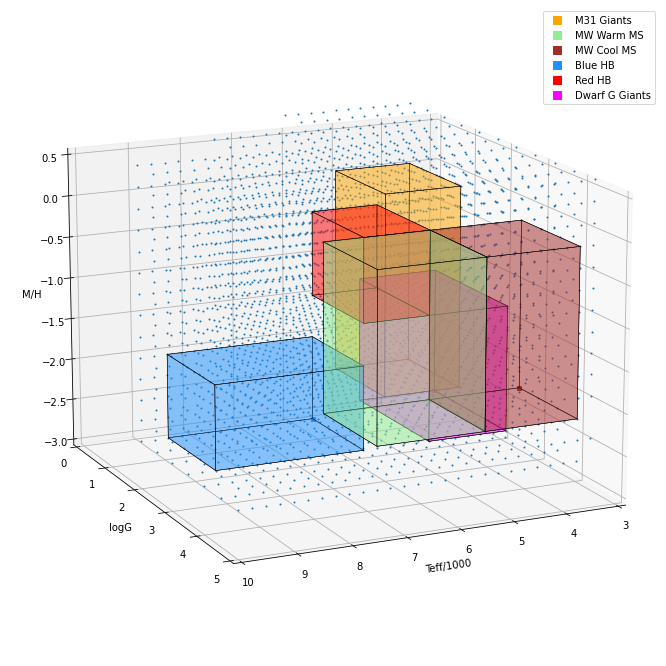

In [102]:
#----------------------------------------
# create a few perspective figures
# will only print if label !=None
#----------------------------------------
showBlocks3D(blk,20,125,'perspective')
showBlocks3D(blk,15,-115,'sideways')

<ipython-input-100-62859022a745>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


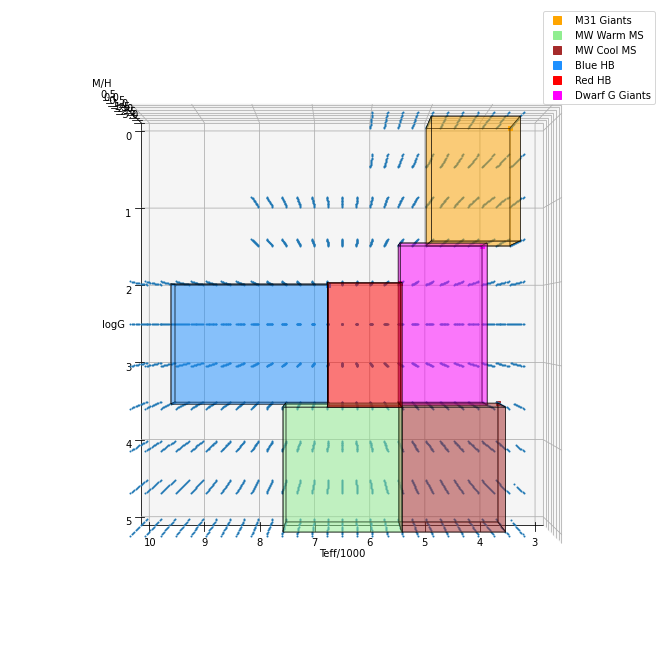

<ipython-input-100-62859022a745>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


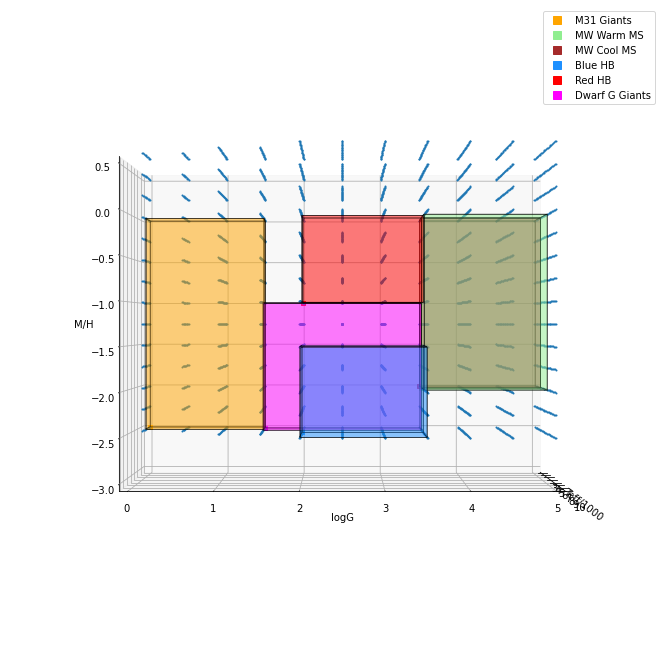

<ipython-input-100-62859022a745>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


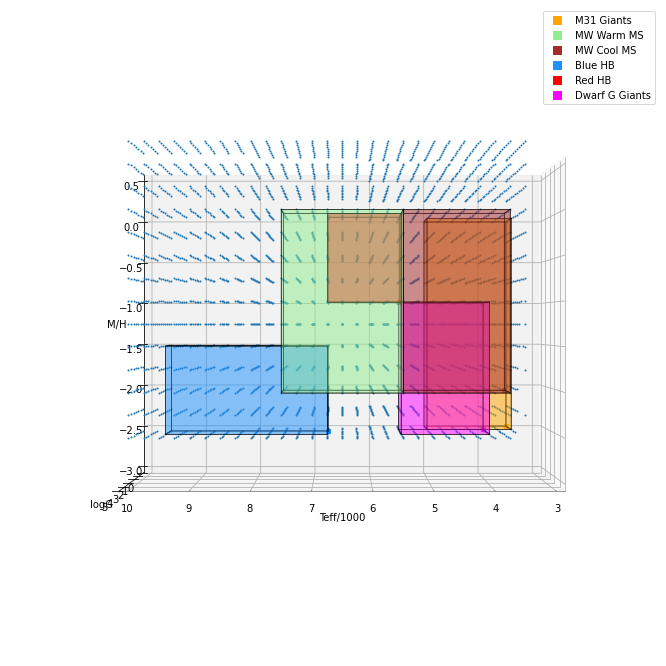

In [103]:
#--------------------------------------
# show the axisparallel projections
#--------------------------------------
showBlocks3D(blk,90,-90,'Teff-logG')
showBlocks3D(blk,0,-180,'logG-M')
showBlocks3D(blk,0,-90,'Teff-M')

## Get RBF script

In [136]:
def get_cmd(R=None):
    print(R, sep="/n/n")
    pp = c.dRs[R][:3]
    base = "./scripts/build_rbf.sh grid bosz --config ./configs/import/stellar/bosz/rbf/"
    out =  f" --out /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_5000_{c.dRR[R]}/"
    param = f" --Fe_H {pp[0][0]} {pp[0][1]} --T_eff {pp[1][0]} {pp[1][1]} --log_g  {pp[2][0]} {pp[2][1]} "
    cmd = base + out + param
    print(cmd)

In [137]:
for R in c.Rnms:
    get_cmd(R)

M
./scripts/build_rbf.sh grid bosz --config ./configs/import/stellar/bosz/rbf/ --out /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_5000_M31G/ --Fe_H -2.5 0.0 --T_eff 3500 5000 --log_g  0.0 1.5 
W
./scripts/build_rbf.sh grid bosz --config ./configs/import/stellar/bosz/rbf/ --out /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_5000_MWW/ --Fe_H -2.0 0.0 --T_eff 5500 7500 --log_g  3.5 5.0 
C
./scripts/build_rbf.sh grid bosz --config ./configs/import/stellar/bosz/rbf/ --out /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_5000_MWC/ --Fe_H -2.0 0.0 --T_eff 3750 5500 --log_g  3.5 5.0 
B
./scripts/build_rbf.sh grid bosz --config ./configs/import/stellar/bosz/rbf/ --out /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_5000_BHB/ --Fe_H -2.5 -1.5 --T_eff 6750 9500 --log_g  2.0 3.5 
R
./scripts/build_rbf.sh grid bosz --config ./configs/import/stellar/bosz/rbf/ --out /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_5000_RHB/ --Fe_H -1.0 0.0 --T_eff 5

In [108]:
pp

[[-1.0, 0.0], [5500, 6750], [2.0, 3.5]]

In [106]:
c.dRs["R"]

[[-1.0, 0.0], [5500, 6750], [2.0, 3.5], [-0.75, 0.5], [-0.25, 0.5]]